In [1]:
# setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# define style do seaborn
sns.set_style('whitegrid')

In [2]:
# carrega o dataset tratado
df_br = pd.read_csv('../data/brasileirao_2014_2024_clean.csv', index_col=0)

# exibe informações sobre o dataframe
df_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3800 entries, 0 to 4085
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ano_campeonato          3800 non-null   int64  
 1   rodada                  3800 non-null   int64  
 2   estadio                 3800 non-null   object 
 3   publico                 3800 non-null   float64
 4   publico_max             3800 non-null   float64
 5   arbitro                 3800 non-null   object 
 6   time_mandante           3800 non-null   object 
 7   gols_mandante           3800 non-null   float64
 8   time_visitante          3800 non-null   object 
 9   gols_visitante          3800 non-null   float64
 10  escanteios_mandante     1880 non-null   float64
 11  escanteios_visitante    1880 non-null   float64
 12  faltas_mandante         1880 non-null   float64
 13  faltas_visitante        1880 non-null   float64
 14  impedimentos_mandante   1880 non-null   float

In [3]:
# define o vencedor com base nos gols e atribui "empate" se os gols forem iguais
df_br['vencedor'] = np.select(
    [df_br['gols_mandante'] > df_br['gols_visitante'], df_br['gols_mandante'] < df_br['gols_visitante']],
    [df_br['time_mandante'], df_br['time_visitante']],
    default='Empate'
)

# calcula a quantidade de pontos feitos como mandante/visitante
# vitória = 3 pontos; empate = 1 ponto; derrota = 0 pontos
df_br['pontos_mandante'] = np.select(
    [df_br['vencedor'] == df_br['time_mandante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

df_br['pontos_visitante'] = np.select(
    [df_br['vencedor'] == df_br['time_visitante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

In [4]:
# cálculo da taxa de aproveitamento de pontos - times mandantes/casa
aprov_mandante = (
    df_br
    .groupby(['ano_campeonato', 'time_mandante'])
    .agg(
        partidas_mandante=('pontos_mandante', 'size'),
        pontos_mandante=('pontos_mandante', 'sum')        
    )
    .assign(aproveitamento_mandante=lambda df: df['pontos_mandante'] / (df['partidas_mandante'] * 3))
    .rename_axis(['ano_campeonato', 'time'])
    .reset_index()
)

# cálculo da taxa de aproveitamento de pontos - times visitantes/fora
aprov_visitante = (
    df_br
    .groupby(['ano_campeonato', 'time_visitante'])
    .agg(
        partidas_visitante=('pontos_visitante', 'size'),
        pontos_visitante=('pontos_visitante', 'sum')        
    )
    .assign(aproveitamento_visitante=lambda df: df['pontos_visitante'] / (df['partidas_visitante'] * 3))
    .rename_axis(['ano_campeonato', 'time'])
    .reset_index()
)

# junção das bases de aproveitamento de pontos
df_aproveitamento = (
    aprov_mandante
    .merge(aprov_visitante, on=['ano_campeonato', 'time'])
    .assign(desvio_aproveitamento=lambda df: df['aproveitamento_mandante'] - df['aproveitamento_visitante'])
    .sort_values(by=['ano_campeonato', 'time'], ascending=True)
)

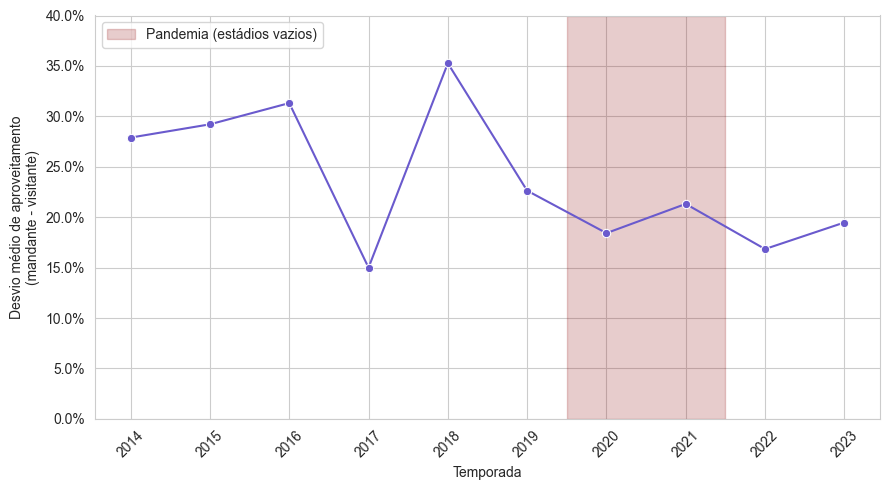

In [5]:
# check se há redução no efeito mandante durante a pandemia
# resposta curta: queda da diferença mandante/visitante acontece já a partir de 2019
desvio_temporada = (
    df_aproveitamento
    .groupby('ano_campeonato')
    .agg(desvio_aproveitamento=('desvio_aproveitamento', 'mean'))
    .reset_index()
)

plt.figure(figsize=(9, 5))

sns.lineplot(
    data=desvio_temporada,
    x='ano_campeonato',
    y='desvio_aproveitamento',
    marker='o',
    color='slateblue'
)

plt.axvspan(2019.5, 2021.5, color='darkred', alpha=0.2, label='Pandemia (estádios vazios)')
plt.legend()

plt.xlabel('Temporada')
plt.ylabel('Desvio médio de aproveitamento\n(mandante - visitante)')

plt.xticks(desvio_temporada['ano_campeonato'], rotation=45)
plt.ylim([0, 0.4])

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

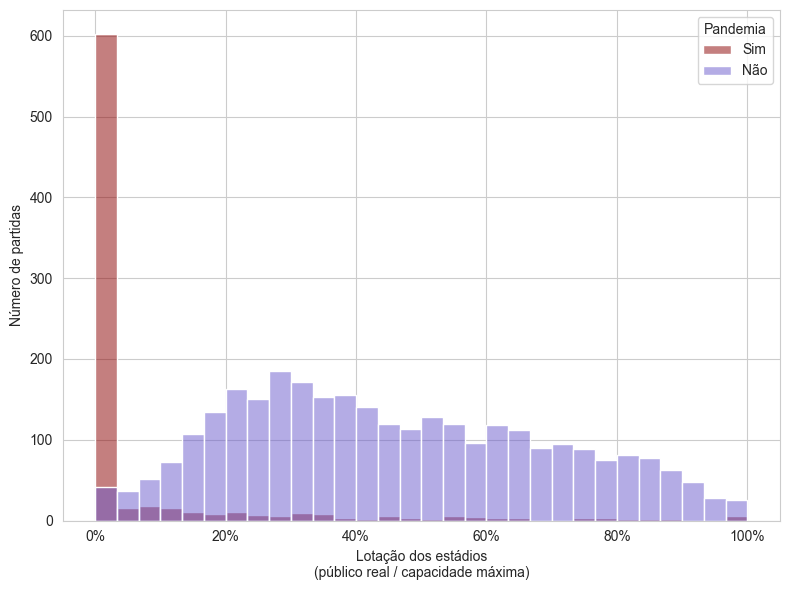

In [6]:
# identifica partidas sem público nos anos de pandemia (2020 e 2021) 
df_br['pandemia'] = df_br['ano_campeonato'].isin([2020, 2021]).astype(int)

# define variável lotação dos estádios (público real / capacidade máxima)
df_br['lotacao_estadio'] = (df_br['publico'] / df_br['publico_max']).clip(upper=1)

# distribuição da variável de lotação dos estádios vs dummy de pandemia
plt.figure(figsize=(8, 6))

sns.histplot(
    data = df_br,
    x='lotacao_estadio', 
    bins=30,
    hue='pandemia',
    palette={0: 'slateblue', 1: 'darkred'}
)

plt.legend(title='Pandemia', labels=['Sim', 'Não'])

plt.xlabel('Lotação dos estádios\n(público real / capacidade máxima)')
plt.ylabel('Número de partidas')

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

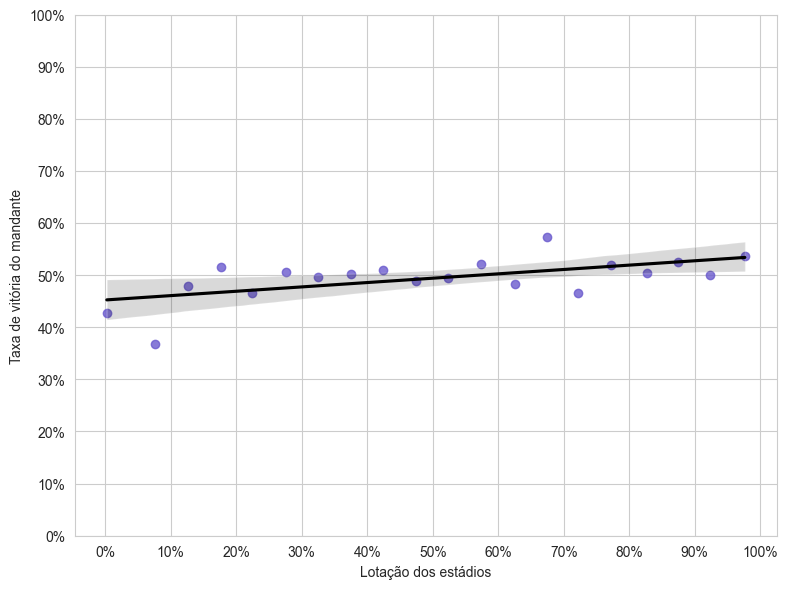

In [7]:
# define bins para categorizar a lotação dos estádios
df_br['bins_lotacao'] = pd.cut(df_br['lotacao_estadio'], bins=20)

# define variável que identifica vitória do mandante
df_br['vitoria_mandante'] = (df_br['pontos_mandante'] == 3).astype(int)

# dataframe agrupado pelos bins da lotação contendo:
# a) número total de partidas; b) lotação média dos jogos; c) probabilidade de vitória do mandante
lotacao_vitoria = (
    df_br
    .groupby('bins_lotacao', observed=False)
    .agg(
        n_partidas=('vitoria_mandante', 'count'),
        lotacao_media=('lotacao_estadio', 'mean'),
        prob_vitoria_mandante=('vitoria_mandante', 'mean')
    )
    .reset_index()
)

# relação entre lotação dos estádios e probabilidade de vitória dos mandantes: efeito tímido
plt.figure(figsize=(8, 6))

sns.regplot(
    data=lotacao_vitoria,
    x='lotacao_media',
    y='prob_vitoria_mandante',
    color='slateblue',
    scatter_kws={'alpha': 0.8},
    line_kws={'color': 'black'}
)

plt.xlabel('Lotação dos estádios')
plt.ylabel('Taxa de vitória do mandante')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()


In [8]:
# identificando diferentes combinações de clássicos regionais
classicos = [
    # paulista
    frozenset(['Palmeiras', 'Corinthians']),
    frozenset(['Palmeiras', 'São Paulo']),
    frozenset(['Palmeiras', 'Santos']),
    frozenset(['Corinthians', 'São Paulo']),
    frozenset(['Corinthians', 'Santos']),
    frozenset(['São Paulo', 'Santos']),

    # carioca
    frozenset(['Flamengo', 'Fluminense']),
    frozenset(['Flamengo', 'Vasco da Gama']),
    frozenset(['Flamengo', 'Botafogo']),
    frozenset(['Fluminense', 'Vasco da Gama']),
    frozenset(['Fluminense', 'Botafogo']),
    frozenset(['Vasco da Gama', 'Botafogo']),

    # gaúcho
    frozenset(['Grêmio', 'Internacional']),

    # mineiro
    frozenset(['Atlético-MG', 'Cruzeiro']),
    frozenset(['Atlético-MG', 'América-MG']),
    frozenset(['Cruzeiro', 'América-MG']),

    # paranaense
    frozenset(['Atlético-PR', 'Coritiba']),

    # baiano
    frozenset(['Bahia', 'Vitória']),

    # cearense
    frozenset(['Ceará SC', 'Fortaleza']),

    # goiano
    frozenset(['Atlético-GO', 'Goiás']),

    # pernambucano
    frozenset(['Sport Recife', 'Santa Cruz']),
]

confrontos = df_br[['time_mandante', 'time_visitante']].agg(frozenset, axis=1)
df_br['classico'] = confrontos.isin(classicos).astype(int)

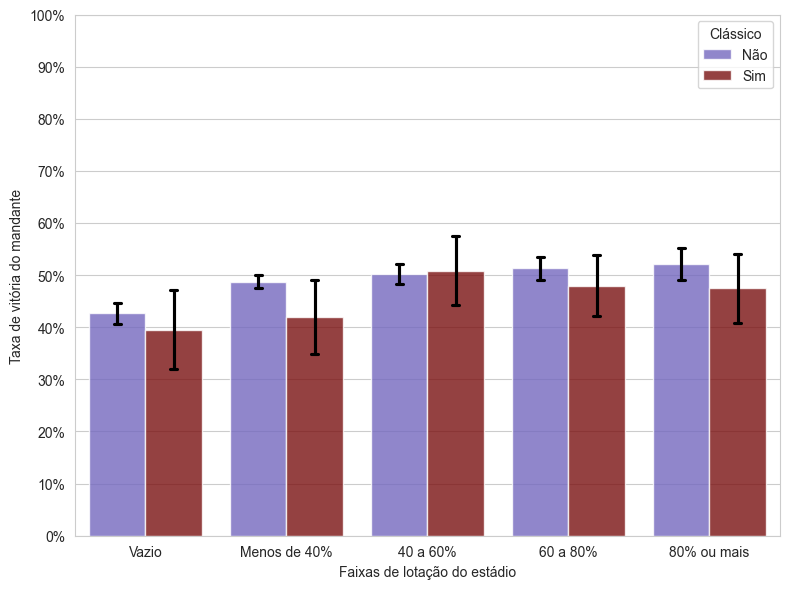

In [13]:
# define variável categórica com faixas de lotação do estádio
df_br['faixa_lotacao'] = pd.cut(
    x=df_br['lotacao_estadio'],
    bins=[-0.1, 0, 0.4, 0.6, 0.8, 1],
    labels=['Vazio', 'Menos de 40%', '40 a 60%', '60 a 80%', '80% ou mais'],
    include_lowest=True
)

# relação entre taxa de vitoria dos mandantes em jogos considerados clássicos ou não
plt.figure(figsize=(8, 6))

ax=sns.barplot(
    data=df_br,
    x='faixa_lotacao',
    y='vitoria_mandante',
    hue='classico',
    palette={0: 'slateblue', 1: 'darkred'},
    alpha=0.8,
    estimator='mean',
    errorbar='se',
    err_kws={'color': 'black'},
    capsize=0.1
)

handles, labels = ax.get_legend_handles_labels()

plt.legend(title='Clássico', handles=handles, labels=['Não', 'Sim'])

plt.ylabel('Taxa de vitória do mandante')
plt.xlabel('Faixas de lotação do estádio')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [10]:
# dataset filtrando apenas anos que possuem informações sobre faltas, impedimentos e escanteios
subset_br = df_br.copy()
subset_br = subset_br.query('ano_campeonato >= 2020')

# gerando variáveis de saldo de eventos
subset_br['saldo_faltas'] = (subset_br['faltas_mandante'] - subset_br['faltas_visitante'])
subset_br['saldo_escanteios'] = (subset_br['escanteios_mandante'] - subset_br['escanteios_visitante'])
subset_br['saldo_impedimentos'] = (subset_br['impedimentos_mandante'] - subset_br['impedimentos_visitante'])


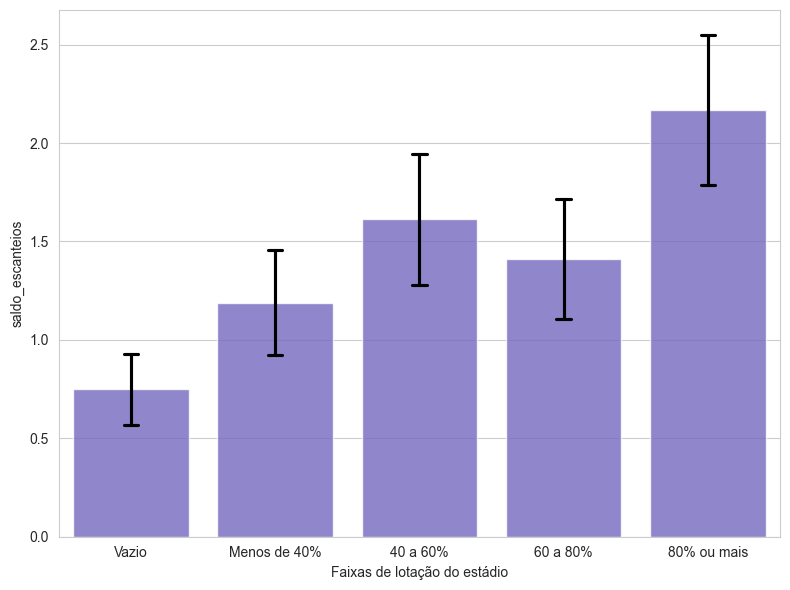

In [11]:
# relação entre taxa de vitoria dos mandantes em jogos considerados clássicos ou não
plt.figure(figsize=(8, 6))

ax=sns.barplot(
    data=subset_br,
    x='faixa_lotacao',
    y='saldo_escanteios',
    color='slateblue',
    alpha=0.8,
    estimator='mean',
    errorbar='se',
    err_kws={'color': 'black'},
    capsize=0.1
)

#plt.ylabel('Taxa de vitória do mandante')
plt.xlabel('Faixas de lotação do estádio')

#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()